In [16]:
import sklearn
import sklearn.ensemble
import numpy as np
# Builtins
import datetime as dt
import pathlib as pl
import sys

# 3rd party modules
import h5py
import pandas as pd

# Local packages
# Some of our team are on Windows - resolve ".." for them!
local_packages_dir = pl.Path("../spaceapps-2022/src").resolve()
# print(local_packages_dir)
sys.path.append(str(local_packages_dir))
import downloaddata as dd
import cdflib

In [51]:
forest_model = sklearn.ensemble.RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=1.0, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False, 
    ccp_alpha=0.0, 
    max_samples=None
)

## Settings

In [10]:
datafile = pl.Path("~/.spacepy/data/omnidata.h5").expanduser().resolve()

In [17]:
if not datafile.exists():
    dd.download_data()

In [18]:
# Add some metadata ourselves to some of the keys we may want to read
# Keys we're ignoring:
# 'ByIMF', 'Bz1', 'Bz2', 'Bz3', 'Bz4', 'Bz5', 'Bz6', 'BzIMF', 'DOY', 'G1', 'G2', 'G3', 'Qbits', 'RDT', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'akp3',
keys_to_read = {
    "Dst": {
        "description": "disturbance storm time index",
        "unit": "nT",
        "url": "https://en.wikipedia.org/wiki/Disturbance_storm_time_index",
    },
    "Kp": {
        "description": "planetary K index",
        "unit": "",
        "url": "https://en.wikipedia.org/wiki/K-index#The_Kp-index_and_estimated_Kp-index",
    },
    "Pdyn": {
        "description": "dynamic pressure",
        "unit": "nPa",
        "url": "https://en.wikipedia.org/wiki/Solar_wind#Pressure",
    },
    "UTC": {
        "description": "datetime (UTC)",
        "unit": "",
        "url": "",
    },
    "dens": {
        "description": "solar wind density",
        "unit": "cm-3",
        "url": "https://en.wikipedia.org/wiki/Solar_wind#Velocity_and_density",
    },
    "velo": {
        "description": "solar wind speed",
        "unit": "km/s",
        "url": "https://en.wikipedia.org/wiki/Solar_wind#Velocity_and_density",
    },
}

In [19]:
# Read our datafile
with h5py.File(datafile,"r") as fo:
    data = {key: fo[key][:] for key in keys_to_read.keys()}

# Convert the bytestring dates to strings
data["UTC"] = [dt.decode("utf8") for dt in data["UTC"]]

# Convert to a dataframe, and change date column to a date index
data = pd.DataFrame(data)
data.set_index(pd.DatetimeIndex(data['UTC']), inplace=True)
data = data.drop(columns=["UTC"])

In [20]:
def look_at_data(data):
    """Get an overview of our data"""
    with pd.option_context('display.precision', 2):
        print(f"First and last rows of data:\n{data}\n")
        print(f"Summary statistics:\n{data.describe()}")

look_at_data(data)

First and last rows of data:
                     Dst    Kp  Pdyn   dens   velo
UTC                                               
1963-11-27 14:00:00   -3   0.7  1.71  10.50  285.0
1963-11-27 15:00:00   -3   0.3  1.95  12.00  285.0
1963-11-27 16:00:00   -1   0.3  1.95  12.00  285.0
1963-11-27 17:00:00   -1   0.3  1.95  12.00  285.0
1963-11-27 18:00:00   -3   1.0  2.30  13.70  290.0
...                  ...   ...   ...    ...    ...
2022-01-19 19:00:00  -20  99.0  0.00   2.67  513.6
2022-01-19 20:00:00  -20  99.0  0.00   2.67  513.6
2022-01-19 21:00:00  -17  99.0  0.00   2.67  513.6
2022-01-19 22:00:00  -15  99.0  0.00   2.67  513.6
2022-01-19 23:00:00  -14  99.0  0.00   2.67  513.6

[509722 rows x 5 columns]

Summary statistics:
             Dst         Kp       Pdyn       dens       velo
count  509722.00  509722.00  509722.00  509722.00  509722.00
mean      -14.14       2.11       2.36       6.93     436.60
std        22.05       1.94       1.71       4.97      98.92
min      -589.00

In [21]:
# Sanitise our data:
# * remove dodgy Kp values at end
# * limit to more recent values
data = data[data["Kp"]<=9]
data = data.loc["1995":]
look_at_data(data)

First and last rows of data:
                     Dst   Kp  Pdyn   dens   velo
UTC                                              
1995-01-01 00:00:00   -2  1.0  2.87  16.30  315.0
1995-01-01 01:00:00    3  1.0  3.28  18.80  315.0
1995-01-01 02:00:00    6  1.0  3.46  19.30  320.0
1995-01-01 03:00:00    5  0.0  2.90  16.40  317.0
1995-01-01 04:00:00    3  0.0  2.51  14.50  313.0
...                  ...  ...   ...    ...    ...
2022-01-15 19:00:00  -31  4.0  0.00   2.67  513.6
2022-01-15 20:00:00  -29  4.0  0.00   2.67  513.6
2022-01-15 21:00:00  -35  4.7  0.00   2.67  513.6
2022-01-15 22:00:00  -42  4.7  0.00   2.67  513.6
2022-01-15 23:00:00  -42  4.7  0.00   2.67  513.6

[237048 rows x 5 columns]

Summary statistics:
             Dst         Kp       Pdyn       dens       velo
count  237048.00  237048.00  237048.00  237048.00  237048.00
mean      -11.80       1.78       2.00       6.29     426.26
std        19.41       1.34       1.62       4.96     100.74
min      -422.00       0.00  

In [26]:
try:
    function
    append
except:
    continue

,Dst,Kp,Pdyn,dens,velo
UTC,,,,,
1995-01-01 00:00:00,-2,1.0,2.87,16.299999,315.000000
1995-01-01 01:00:00,3,1.0,3.28,18.799999,315.000000
1995-01-01 02:00:00,6,1.0,3.46,19.299999,320.000000
1995-01-01 03:00:00,5,0.0,2.90,16.400000,317.000000
1995-01-01 04:00:00,3,0.0,2.51,14.500000,313.000000
...,...,...,...,...,...
2022-01-15 19:00:00,-31,4.0,0.00,2.670000,513.599976
2022-01-15 20:00:00,-29,4.0,0.00,2.670000,513.599976
2022-01-15 21:00:00,-35,4.7,0.00,2.670000,513.599976


In [47]:
import datetime
data_velo_and_time = data[['velo']]
data_velo_and_time = data_velo_and_time.iloc[:-2]

velo_plus_one = data[['velo']].iloc[1:-1]
velo_plus_one.index = velo_plus_one.index - pd.Timedelta(1, unit='h')
data_velo_and_time['velo+1'] = velo_plus_one

velo_plus_two = data[['velo']].iloc[2:]
velo_plus_two.index = velo_plus_two.index - pd.Timedelta(2, unit='h')
data_velo_and_time['velo+2'] = velo_plus_two

data_velo_and_time


,velo,velo+1,velo+2
UTC,,,
1995-01-01 00:00:00,315.000000,315.000000,320.000000
1995-01-01 01:00:00,315.000000,320.000000,317.000000
1995-01-01 02:00:00,320.000000,317.000000,313.000000
1995-01-01 03:00:00,317.000000,313.000000,315.000000
1995-01-01 04:00:00,313.000000,315.000000,316.000000
...,...,...,...
2022-01-15 17:00:00,513.599976,513.599976,513.599976
2022-01-15 18:00:00,513.599976,513.599976,513.599976
2022-01-15 19:00:00,513.599976,513.599976,513.599976


In [54]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_velo_and_time, test_size=0.2)
# train['velo']

UTC
1999-03-07 11:00:00    488.0
2017-12-18 03:00:00    597.0
2013-12-14 00:00:00    301.0
2021-08-04 06:00:00    342.0
2004-09-03 18:00:00    359.0
                       ...  
2018-04-12 03:00:00    500.0
2016-06-01 15:00:00    432.0
2014-07-28 07:00:00    391.0
1997-01-07 11:00:00    403.0
2021-05-23 21:00:00    388.0
Name: velo, Length: 189636, dtype: float32

In [55]:
forest_model.fit(train[['velo', 'velo+1']], train['velo+2'])

RandomForestRegressor()

In [56]:
test_preds = forest_model.predict(test[['velo', 'velo+1']])
test_preds

array([341.09555076, 491.04292319, 398.28718962, ..., 719.16      ,
       456.17480064, 593.62823665])

In [66]:
test['velo+2_preds'] = test_preds
test['velo+2']


UTC
1996-09-04 11:00:00    348.0
2005-02-19 11:00:00    481.0
2016-04-18 01:00:00    391.0
2022-01-03 06:00:00    533.0
2000-10-12 12:00:00    338.0
                       ...  
2018-12-09 04:00:00    552.0
2002-03-24 03:00:00    460.0
2002-12-27 11:00:00    721.0
2005-03-18 22:00:00    463.0
2015-04-17 21:00:00    594.0
Name: velo+2, Length: 47410, dtype: float32

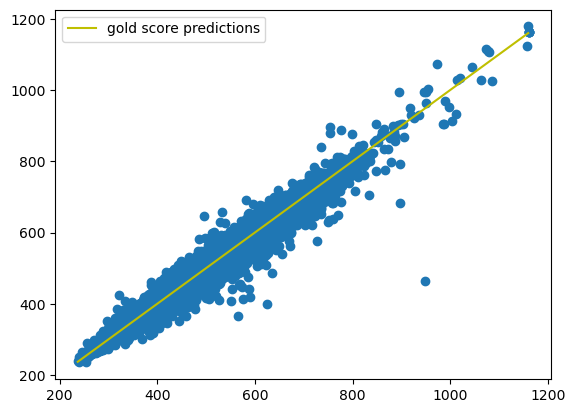

In [83]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(test['velo+2'], test['velo+2_preds'])
plt.plot(np.arange(test['velo+2'].min(), test['velo+2'].max()),np.arange(test['velo+2'].min(), test['velo+2'].max()), c='y', label='gold score predictions')
plt.legend()
plt.show()

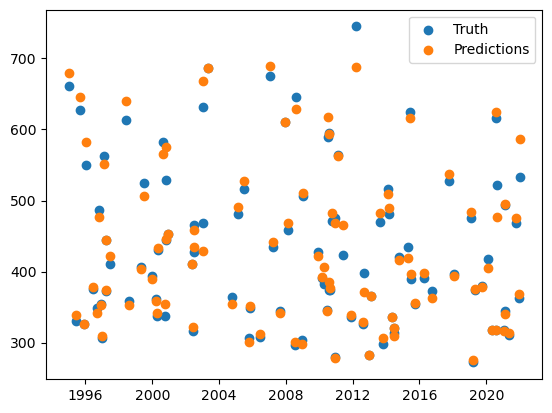

In [79]:
import matplotlib.pyplot as plt
plt.figure()
test_reduced = test.iloc[:100]
plt.scatter(test_reduced.index, test_reduced['velo+2'], label='Truth')
plt.scatter(test_reduced.index, test_reduced['velo+2_preds'], label='Predictions')
plt.legend()
plt.show()